In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart <- read_delim(url, delim = ",", 
                    col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","predicted_attribute"))
head(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,predicted_attribute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
heart_clean <- select(heart, "age", "trestbps", "chol", "predicted_attribute")
colnames(heart_clean) <- c("age","blood_pressure","cholesterol","heart_diagnosis")
head(heart_clean)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,0
67,160,286,2
67,120,229,1
37,130,250,0
41,130,204,0
56,120,236,0


In [4]:
heart_filter <- filter(heart_clean, heart_diagnosis == 1 | heart_diagnosis == 2 | heart_diagnosis == 3 |heart_diagnosis == 4)|>
    mutate(heart_diagnosis = "yes")
heart_data <- filter(heart_clean, heart_diagnosis == 0)|>
    mutate(heart_diagnosis = "no")|>
    bind_rows(heart_filter)|>
    mutate(heart_diagnosis = as.factor(heart_diagnosis))
head(heart_data)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,no
37,130,250,no
41,130,204,no
56,120,236,no
57,120,354,no
57,140,192,no


In [5]:
set.seed(1145)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [6]:
heart_recipe <- recipe(heart_diagnosis ~ age + blood_pressure + cholesterol, data = heart_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

In [33]:
#Choosing a K value by performing a 5-fold cross validation to determine the K value between 1 and 10 that has the highest accuracy
heart_vfold <- vfold_cv(heart_training, v =5, strata = heart_diagnosis)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
k_vals <- tibble(neighbors = seq(from =1, to = 50, by = 1))
knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

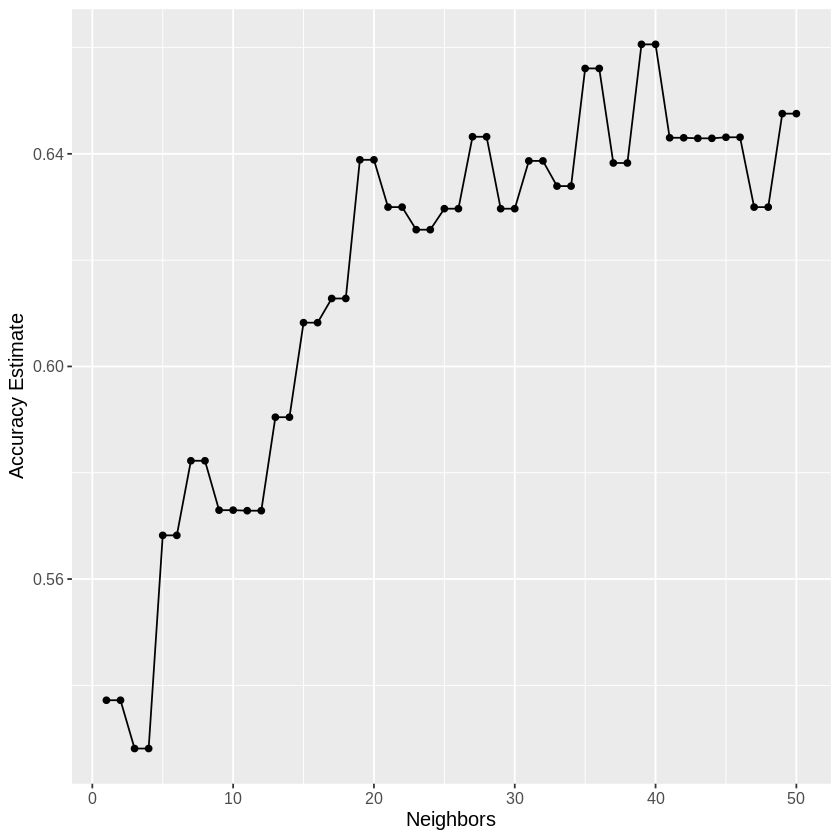

In [34]:
#We now collect the accuracies of these different Ks and then display them as a graph of the K versus accuracy to determine the appropriate value
accuracies <- knn_results |>
    filter(.metric == "accuracy")|>
    
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

accuracy_vs_k

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 41)|>
    set_engine("kknn")|>
    set_mode("classification")

In [19]:
knn_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    fit(data = heart_training)

In [28]:
heart_test_prediction <- predict(knn_fit, heart_testing)|>
    bind_cols(heart_testing)

heart_prediction_accuracy <- heart_test_prediction |>
         metrics(truth = heart_diagnosis, estimate = .pred_class)|>
        filter(.metric == "accuracy")

heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5394737


In [27]:
Confusion <- heart_test_prediction |>
    conf_mat(truth =  heart_diagnosis, estimate = .pred_class)
Confusion

          Truth
Prediction no yes
       no  20  14
       yes 21  21